In [1]:
from torch._tensor import Tensor
from torch.utils.data import Dataset
from utils import read_npy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import MSELoss
import torchvision.transforms as transforms

class PixelDataset(Dataset):
    def __init__(self, sprites_path, labels_path) -> None:
        self.sprites = read_npy(sprites_path)
        self.labels = read_npy(labels_path)

        self.transform = transforms.Lambda(
                    lambda x: x / 255.
                )  # Normalize to range [-1, 1]

    def __len__(self) -> int:
        return len(self.sprites)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image = self.transform(self.sprites[index].permute(2, 0, 1))
        label = self.labels[index]
        return image, label

c:\Users\jurko\anaconda3\envs\image-generator\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader

In [3]:
dataset = PixelDataset("../dataset/sprites.npy", "../dataset/sprites_labels.npy")
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

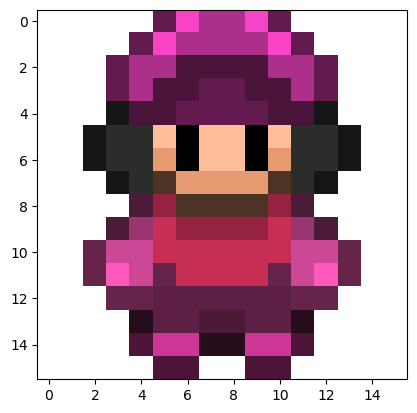

In [4]:
plt.imshow(dataset[0][0].permute(1,2,0))

In [5]:
len(dataset)
print(dataset[0][0].max())
print(dataset[0][0].min())

tensor(1.)
tensor(0.)


In [6]:
for image, label in dataloader:
    print(image[0].shape)
    print(label)
    break

torch.Size([3, 16, 16])
tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]])


In [7]:
from models.autoencoder import Encoder, Decoder


In [8]:
encoder = Encoder()
decoder = Decoder()
autoencoder = nn.Sequential(encoder, decoder)


In [9]:
# output = autoencoder(next(iter(dataloader))[0])
# output = torch.stack([image.permute(2,0,1).int() for image in output])
# grid = make_grid(output, nrow=4, padding = 2)
# plt.imshow(grid.permute(1,2,0))
# plt.show()

In [23]:
subset = torch.utils.data.Subset(dataset, range(8))
# print(len(dataset))
dataloader = DataLoader(subset, batch_size=4, shuffle=True, num_workers=0)


In [24]:

optimizer = Adam(autoencoder.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [25]:

def get_gradient_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [33]:
from tqdm.auto import tqdm
def train_loop(dataloader, model, loss_fn, optimizer, epochs=5) -> tuple[list, list]:
    model.train()
    size = len(dataloader.dataset)
    losses = []
    gradients = []
    try:
        for epoch in tqdm(range(epochs)):
            # print(f"Epoch {epoch+1}\n-------------------------------")
            for batch, (X, label) in enumerate(dataloader):
                # Compute prediction error
                pred = model(X)
                loss = loss_fn(pred, X)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()

                
                gradients.append(get_gradient_norm(model))
                losses.append(loss.item())
                if batch % 32 == 0:
                    loss, current = loss.item(), batch * len(X)
                    # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            scheduler.step()
    except KeyboardInterrupt:
        pass

    return losses, gradients

In [35]:
losses, gradients = train_loop(dataloader, autoencoder, MSELoss(), optimizer, epochs=100)

100%|██████████| 100/100 [00:01<00:00, 87.40it/s]


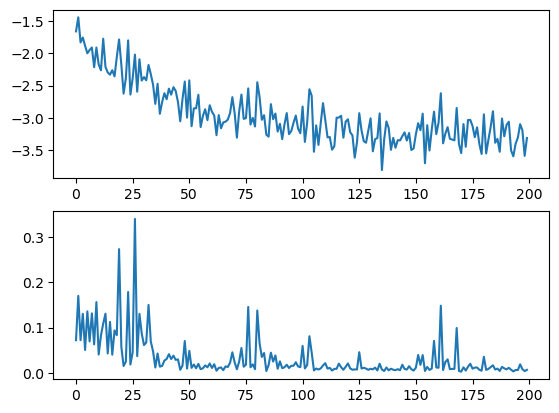

In [28]:

fig, axes = plt.subplots(2)
axes[0].plot(torch.log10(torch.tensor(losses)))
axes[1].plot(gradients)
plt.show()

torch.Size([3, 16, 16])
torch.Size([4, 3, 16, 16])
torch.Size([3, 20, 74])


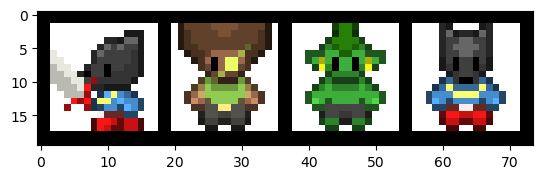

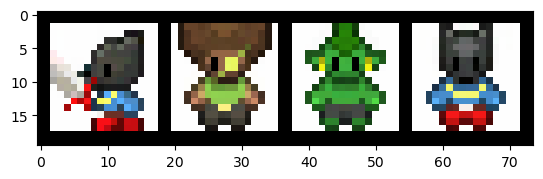

AttributeError: 'Sequential' object has no attribute 'decoder'

In [29]:
dataset[0][0]
def show(autoencoder):
    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt
    autoencoder.eval()
    images_not, _ = next(iter(dataloader))
    images = torch.stack([image for image in images_not[:8]])
    print(images[3].int().shape)
    print(images.shape)
    grid = make_grid(images, nrow=4, padding = 2)
    print(grid.shape)
    plt.imshow(grid.permute(1,2,0))

    plt.show()

    autoencoder.eval()
    with torch.no_grad():
        output = autoencoder(images_not[:8])
        output = torch.stack([image for image in output])
        grid = make_grid(output, nrow=4, padding = 2)
        plt.imshow(grid.permute(1,2,0))
        plt.show()

    with torch.no_grad():
        images_not = torch.randn(8,30)
        output = autoencoder.decoder(images_not[:8])
        output = torch.stack([image.int() for image in output])
        grid = make_grid(output, nrow=4, padding = 2)
        plt.imshow(grid.permute(1,2,0))
        plt.show()

show(autoencoder)



# CONV Autoencoder

In [6]:
class ConvEncoder(nn.Module):
    def __init__(self) -> None:
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), padding="same"
            ),  # mx16x16x3 -> mx16x16x16
            nn.MaxPool2d(kernel_size=(2, 2)),  #mx16x8x8
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2,2)), #mx32x8x8
            nn.MaxPool2d(kernel_size=(2, 2), padding=1),  #mx32x4x4
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=(2,2), padding = "same"), #mx64x4x4
            nn.MaxPool2d(kernel_size=(2, 2)), #mx64x2x2,
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=(2,2), padding = "same"), #mx128x2x2
            nn.MaxPool2d(kernel_size=(2, 2)), #mx128x1x1,
            nn.Flatten() # mx128
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [95]:
class ConvDecoder(nn.Module):
    def __init__(self) -> None:
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (-1, 1, 1)),  # mx128x1x1
            nn.Upsample(scale_factor=2),  # mx128x2x2
            nn.Conv2d(128, 64, kernel_size=(2, 2), padding="same"),  # mx128x2x2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=(2, 2), padding="same"),  # mx32x4x4
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, kernel_size=(2, 2), padding="same"),  # mx16x8x8
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=(2, 2), padding="same"),  # mx16x16x16
            # nn.Conv2d(16, 3, kernel_size=(2, 2), padding="same"),  # mx3x16x16
            nn.Flatten(1),
            nn.Linear(16 * 16 * 16, 3 * 16 * 16),
            nn.ReLu(),
            nn.Unflatten(1, (3, 16, 16)),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.decoder(x)
        return x

In [103]:
class ConvEncoder(nn.Module):
    def __init__(self) -> None:
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), padding="same"
            ),  # mx16x16x3 -> mx16x16x16
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),  # mx16x8x8
            # nn.Dropout(0.3),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2)),  # mx32x8x8
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(kernel_size=(2, 2), padding=1),  # mx32x4x4
            # nn.Conv2d(
            #     in_channels=32, out_channels=64, kernel_size=(2, 2), padding="same"
            # ),  # mx64x4x4
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(kernel_size=(2, 2)),  # mx64x2x2,
            # nn.Conv2d(
            #     in_channels=64, out_channels=128, kernel_size=(2, 2), padding="same"
            # ),  # mx128x2x2
            # nn.MaxPool2d(kernel_size=(2, 2)),  # mx128x1x1,
            nn.Flatten(),  # mx128 #mx64x2x2
            nn.Linear(16*8*8, 128),
            nn.LeakyReLU(0.2,inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        return x


class ConvDecoder(nn.Module):
    def __init__(self) -> None:
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (-1, 1, 1)),  # mx128x1x1
            nn.Upsample(scale_factor=2),  # mx128x2x2
            nn.Conv2d(128, 64, kernel_size=(2, 2), padding="same"),  # mx64x2x2
            nn.BatchNorm2d(64),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(64, 32, kernel_size=(2, 2), padding="same"),  # mx32x4x4
            # nn.BatchNorm2d(32),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(32, 16, kernel_size=(2, 2), padding="same"),  # mx16x8x8
            # nn.BatchNorm2d(16),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(16, 16, kernel_size=(2, 2), padding="same"),  # mx16x16x16
            # nn.BatchNorm2d(16),
            # nn.Conv2d(16, 3, kernel_size=(2, 2), padding="same"),  # mx3x16x16
            nn.Flatten(1),
            # nn.Linear(16 * 16 * 16, 3 * 16 * 16),
            nn.Linear(64*2*2, 3 * 16 * 16),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 16, 16)),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.decoder(x)
        return x


class ConvAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()
        self.autoencoder = nn.Sequential(self.encoder, self.decoder)

    def forward(self, x: Tensor) -> Tensor:
        o = self.autoencoder(x)
        return o


In [104]:

images = dataset[0][0].unsqueeze(0)
print(images.shape)
# images, _ = next(iter(dataloader))
conv = ConvEncoder()
out = conv(images)
out.shape
out = torch.cat((out, torch.zeros((255, 128))), dim = 0)
print(out.shape)
dec = ConvDecoder()
dec(out).shape

torch.Size([1, 3, 16, 16])
torch.Size([256, 128])


torch.Size([256, 3, 16, 16])

In [105]:
auto = ConvAutoEncoder()
optimizer = Adam(auto.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)
auto(images).shape

torch.Size([1, 3, 16, 16])

In [106]:
losses, gradients = train_loop(dataloader, auto, MSELoss(), optimizer, epochs=100)

Epoch 1
-------------------------------
loss: 0.176025  [    0/   32]
Epoch 2
-------------------------------
loss: 0.081120  [    0/   32]
Epoch 3
-------------------------------
loss: 0.050965  [    0/   32]
Epoch 4
-------------------------------
loss: 0.061537  [    0/   32]
Epoch 5
-------------------------------
loss: 0.044325  [    0/   32]
Epoch 6
-------------------------------
loss: 0.033973  [    0/   32]
Epoch 7
-------------------------------
loss: 0.044722  [    0/   32]
Epoch 8
-------------------------------
loss: 0.056453  [    0/   32]
Epoch 9
-------------------------------
loss: 0.049681  [    0/   32]
Epoch 10
-------------------------------
loss: 0.051258  [    0/   32]
Epoch 11
-------------------------------
loss: 0.028659  [    0/   32]
Epoch 12
-------------------------------
loss: 0.034248  [    0/   32]
Epoch 13
-------------------------------
loss: 0.037584  [    0/   32]
Epoch 14
-------------------------------
loss: 0.029688  [    0/   32]
Epoch 15
------

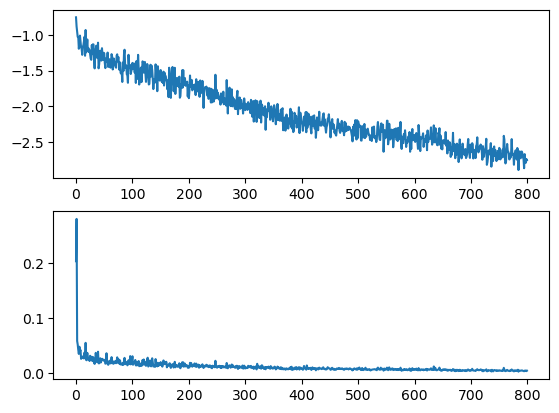

In [107]:

fig, axes = plt.subplots(2)
axes[0].plot(torch.log10(torch.tensor(losses)))
axes[1].plot(gradients)
plt.show()

torch.Size([3, 16, 16])
torch.Size([4, 3, 16, 16])
torch.Size([3, 20, 74])


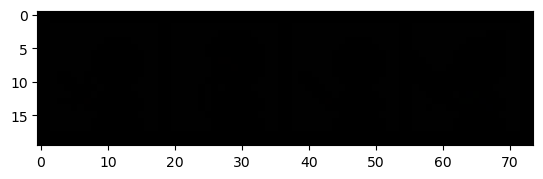

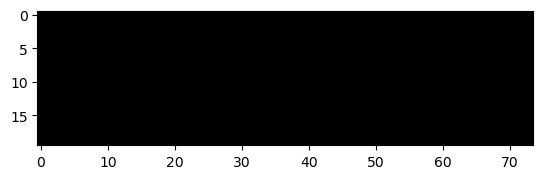

RuntimeError: Given groups=1, weight of size [64, 128, 2, 2], expected input[8, 30, 3, 3] to have 128 channels, but got 30 channels instead

In [108]:
show(auto)

# VAE

In [5]:
def kl_divergence_loss(q_dist) -> torch.Tensor:
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)


reconstruction_loss = nn.MSELoss(reduction="sum")


def vae_loss(reconstructed_images, images, encoding) -> float:
    return (
        reconstruction_loss(reconstructed_images, images)
        + kl_divergence_loss(encoding).sum()
    )


class Encoder(nn.Module):
    """
    Encoder Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    """

    def __init__(self, im_chan=1, output_chan=128, hidden_dim=16) -> None:
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            # self.make_disc_block(im_chan, hidden_dim),
            # self.make_disc_block(hidden_dim, hidden_dim * 2),
            # self.make_disc_block(
            #     hidden_dim * 2, output_chan * 2, kernel_size=2, final_layer=True
            # ),
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), padding="same"
            ),  # mx16x16x3 -> mx16x16x16
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),  # mx16x8x8
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2)),  # mx32x8x8
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2), padding=1),  # mx32x4x4
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=(2, 2), padding="same"
            ),  # mx64x4x4
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2)),  # mx64x2x2,
            # nn.Conv2d(
            #     in_channels=64, out_channels=128, kernel_size=(2, 2), padding="same"
            # ),  # mx128x2x2
            # nn.MaxPool2d(kernel_size=(2, 2)),  # mx128x1x1,
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=(2, 2), padding="same"
            ),  # mx64x4x4
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(kernel_size=(2, 2)),  # mx64x2x2,
            # nn.Conv2d(
            #     in_channels=128, out_channels=256, kernel_size=(2, 2), padding="same"
            # ),  # mx64x4x4
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(kernel_size=(2, 2)),  # mx64x2x2,
            nn.Flatten(),  # mx128 #mx64x2x2
            nn.Linear(128 * 2 * 2, 2*self.z_dim),
            # nn.ReLU(inplace=True),
        )

    def make_disc_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        final_layer=False,
    ) -> nn.Sequential:
        """
        Function to return a sequence of operations corresponding to a encoder block of the VAE,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        """
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Function for completing a forward pass of the Encoder: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        """
        disc_pred = self.disc(image)
        print(disc_pred.shape)
        encoding = disc_pred.view(len(disc_pred), -1)
        # The stddev output is treated as the log of the variance of the normal
        # distribution by convention and for numerical stability
        return encoding[:, : self.z_dim], encoding[:, self.z_dim :].exp()

class Decoder(nn.Module):
    """
    Decoder Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    """

    def __init__(self, z_dim=32, im_chan=1, hidden_dim=16) -> None:
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            # self.make_gen_block(z_dim, hidden_dim * 4),  # 3x3
            # self.make_gen_block(
            #     hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1
            # ),  # 6x6
            # self.make_gen_block(
            #     hidden_dim * 2, hidden_dim, kernel_size=2, stride=2
            # ),  # 12x12
            # self.make_gen_block(
            #     hidden_dim, im_chan, kernel_size=5, stride=1, final_layer=True
            # ),  # 26x26
            nn.Unflatten(1, (-1, 1, 1)),  # mx128x1x1
            nn.Upsample(scale_factor=2),  # mx128x2x2
            nn.Conv2d(128, 64, kernel_size=(2, 2), padding="same"),  # mx128x2x2
            nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=(2, 2), padding="same"),  # mx32x4x4
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, kernel_size=(2, 2), padding="same"),  # mx16x8x8
            nn.BatchNorm2d(16),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=(2, 2), padding="same"),  # mx16x16x16
            nn.BatchNorm2d(16),
            # nn.Conv2d(16, 3, kernel_size=(2, 2), padding="same"),  # mx3x16x16
            nn.Flatten(1),
            nn.Linear(16 * 16 * 16, 3 * 16 * 16),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 16, 16)),
        )

    def make_gen_block(
        self,
        input_channels,
        output_channels,
        kernel_size=3,
        stride=2,
        final_layer=False,
    ) -> nn.Sequential:
        """
        Function to return a sequence of operations corresponding to a Decoder block of the VAE,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        """
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                nn.Sigmoid(),
            )

    def forward(self, noise) -> torch.Tensor:
        """
        Function for completing a forward pass of the Decoder: Given a noise vector,
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        """
        # x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)

In [6]:
images = dataset[0][0].unsqueeze(0)
print(images.shape)
from torch.distributions.normal import Normal
# images, _ = next(iter(dataloader))
conv = Encoder()
out = conv(images)
out[0].shape, out[1].shape
# out = torch.cat((out, torch.zeros((255, 128))), dim = 0)
# print(out.shape)
dec = Decoder()
q_mean, q_stddev = out
q_dist = Normal(q_mean, q_stddev)
z_sample = (
    q_dist.rsample()
)
print(z_sample.shape)
dec(z_sample).shape

torch.Size([1, 3, 16, 16])
torch.Size([1, 256])
torch.Size([1, 128])


c:\Users\jurko\anaconda3\envs\image-generator\Lib\site-packages\torch\nn\modules\conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([1, 3, 16, 16])

# Diffusion

In [24]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, last_layer = False) -> None:
        super(UnetUp, self).__init__()
        
        self.up = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(in_channels, out_channels, kernel_size=1))
        self.conv = nn.Sequential(nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True), nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True) if not last_layer else nn.Sigmoid())

    def forward(self, x, resx):
        x = self.up(x)
        x = torch.cat([x, resx], dim=1)
        x = self.conv(x)
        return x
    
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(UnetDown, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.GELU(), nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.GELU())
        self.down = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        return x
    
class DiffusionModel(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers) -> None:
        super(DiffusionModel, self).__init__()
        self.downs = nn.ModuleList([UnetDown(in_channels if i == 0 else out_channels * i, out_channels * (i + 1)) for i in range(num_layers)])
        self.ups = nn.ModuleList([UnetUp(out_channels*(num_layers - i), out_channels*(num_layers - 1 - i) if i != num_layers - 1 else in_channels, last_layer = i == num_layers-1) for i in range(num_layers)])

        
    def forward(self, x):
        resx = []
        for down in self.downs:
            resx.append(x)
            x = down(x)
        resx = resx[::-1]
        for up, res in zip(self.ups, resx):
            x = up(x, res)
        
        return x

In [25]:
images = dataset[0][0].unsqueeze(0)
print(images.shape)
down = UnetDown(3, 16)
diff = DiffusionModel(3, 16, 4)
diff(images).shape


torch.Size([1, 3, 16, 16])


torch.Size([1, 3, 16, 16])